# Интернет магазин из Азии. A/B-тест новой платежной воронки

Автор: Юрий Кузнецов

Дата: 13.05.2025

В этом проекте мы будем анализировать данные крупного интернет-магазина, который работает преимущественно в Азии. Магазин недавно провёл А/B-тест, чтобы проверить новую платёжную воронку: гипотеза заключалась в том, что новая платёжная воронка увеличит конверсию в покупку. Необходимо проанализировать результаты А/B-теста, который назывался `new_payment_funnel_test_summer_2025`.

## Описание данных


На календаре 21 июня 2025 года, и тест завершился. Нам понадобится поработать со следующими файлами:
- `new_users_test_2025.csv` — данные всех пользователей, зарегистрировавшихся в интернет-магазине с 1 по 14 июня 2025 года.
- `sessions_test_2025.csv` — данные всех сессий новых пользователей с 1 по 21 июня 2025 года. 
- `purchases_test_2025.csv` — данные всех покупок новых пользователей с 1 по 21 июня 2025 года.
- `participants_test_2025.csv` — данные участников тестов.
Структура данных выглядит следующим образом:
Таблица `new_users_test_2025.csv` состоит из полей:
- `user_id` — уникальный идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион, к которому относится пользователь;
- `device` — устройство, с которого происходила регистрация.
Таблица `sessions_test_2025.csv` состоит из полей:
- `user_id` — уникальный идентификатор пользователя;
- `session_start` — дата начала сессии;
- `session_duration` — длительность сессии в минутах.
Таблица `purchases_test_2025.csv` состоит из полей:
- `user_id` — уникальный идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `revenue` — стоимость покупки в долларах.
Таблица `participants_test_2025.csv` состоит из полей:
- `user_id` — уникальный идентификатор пользователя;
- `group` — группа А/B-теста;
- `ab_test` — название А/B-теста.

## Шаг 1. Загрузка и предобработка данных

- Импортируем все библиотеки, необходимые для исследования

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower
from math import ceil
import numpy as np

- Загрузим данные и сохраним в датафреймы 

In [2]:
new_users_test_2025 = pd.read_csv('new_users_test_2025.csv')
sessions_test_2025 = pd.read_csv('sessions_test_2025.csv')
purchases_test_2025 = pd.read_csv('purchases_test_2025.csv')
participants_test_2025 = pd.read_csv('participants_test_2025.csv')

**new_users_test_2025:**

In [3]:
new_users_test_2025.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2025-06-01,South Asia,iPhone
1,F1C668619DFE6E65,2025-06-01,Southeast Asia,iPhone
2,2E1BF1D4C37EA01F,2025-06-01,Central Asia,Mac
3,50734A22C0C63768,2025-06-01,Central Asia,Android
4,E1BDDCE0DAFA2679,2025-06-01,Southeast Asia,iPhone


In [4]:
new_users_test_2025['first_date'] = pd.to_datetime(new_users_test_2025['first_date'])

In [5]:
new_users_test_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131486 entries, 0 to 131485
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     131486 non-null  object        
 1   first_date  131486 non-null  datetime64[ns]
 2   region      131486 non-null  object        
 3   device      131486 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 4.0+ MB


- Датасет `new_users_test_2025` состоит из 131486 строк и 4 столбцов и содержит данные всех пользователей, зарегистрировавшихся в интернет-магазине с 1 по 14 июня 2025 года. Пропусков нет. Поле с временем и датой приведено к соответствующему типу.

**sessions_test_2025:**

In [6]:
sessions_test_2025.head()

,user_id,session_start,session_duration
0,D72A72121175D8BE,2025-06-01 05:51:20,1.0
1,F1C668619DFE6E65,2025-06-01 15:28:14,5.0
2,2E1BF1D4C37EA01F,2025-06-01 16:19:36,3.0
3,50734A22C0C63768,2025-06-01 21:06:51,1.0
4,E1BDDCE0DAFA2679,2025-06-01 10:03:00,2.0


In [7]:
sessions_test_2025['session_start'] = pd.to_datetime(sessions_test_2025['session_start'])

In [8]:
sessions_test_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491443 entries, 0 to 491442
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           491443 non-null  object        
 1   session_start     491443 non-null  datetime64[ns]
 2   session_duration  491443 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 11.2+ MB


- Датасет `sessions_test_2025` состоит из 491443  строк и 3 столбцов и содержит данные всех сессий новых пользователей с 1 по 21 июня 2025 года. Пропусков нет. Поле  `session_start` с временем и датой приведено к соответствующему типу.

**purchases_test_2025:**

In [9]:
purchases_test_2025.head()

,user_id,event_dt,revenue
0,50734A22C0C63768,2025-06-01 21:06:51,4.99
1,0FC21E6F8FAA8DEC,2025-06-01 06:36:08,4.99
2,9CD9F34546DF254C,2025-06-01 14:40:29,99.99
3,1FD7660FDF94CA1F,2025-06-01 04:53:00,4.99
4,E6AF85675078215D,2025-06-01 11:40:09,4.99


In [10]:
purchases_test_2025['event_dt'] = pd.to_datetime(purchases_test_2025['event_dt'])

In [11]:
purchases_test_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149152 entries, 0 to 149151
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   149152 non-null  object        
 1   event_dt  149152 non-null  datetime64[ns]
 2   revenue   149152 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.4+ MB


- Датасет `purchases_test_2025` состоит из 149152 строк и 3 столбцов и содержит данные всех покупок новых пользователей с 1 по 21 июня 2025 года. Пропусков нет. Поле  `event_dt` с временем и датой приведено к соответствующему типу.

**participants_test_2025:**

In [12]:
participants_test_2025.head()

,user_id,group,ab_test
0,6A8825D752FCFFB6,A,new_payment_funnel_test_summer_2025
1,0B75608CBBA59791,B,new_payment_funnel_test_summer_2025
2,6B9D2F7685B83C73,A,new_payment_funnel_test_summer_2025
3,6435D4C2E66A7F75,B,new_payment_funnel_test_summer_2025
4,4F815438BBD2BB7E,A,new_payment_funnel_test_summer_2025


In [13]:
participants_test_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3291 entries, 0 to 3290
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  3291 non-null   object
 1   group    3291 non-null   object
 2   ab_test  3291 non-null   object
dtypes: object(3)
memory usage: 77.3+ KB


- Датасет `participants_test_2025` состоит из 3291 строк и 3 столбцов и содержит данные участников тестов. Пропусков нет.

In [14]:
participants_test_2025['ab_test'].value_counts()

ab_test
new_payment_funnel_test_summer_2025    3066
new_login_screen_apac                   225
Name: count, dtype: int64

- отфильтруем датасет, оставив только строки, относящиеся к настоящему A/B- тесту.

In [15]:
participants_test_2025 = participants_test_2025[participants_test_2025['ab_test'] != 'new_login_screen_apac']

- Проверим уникальные идентификаторы на пересечения

In [16]:
participants_test_2025.groupby('user_id').agg({'group': 'nunique'}).query('group > 1')


,group
user_id,


Прересечений пользователей между группами A и B не найдено

- Проверим на дубликаты в поле user_id

In [17]:
duplicates = participants_test_2025.duplicated().sum()
duplicates

np.int64(0)

дубликаты не найдены

- Построим круговую диаграмму числа и доли уникальных пользователей для групп A и B.

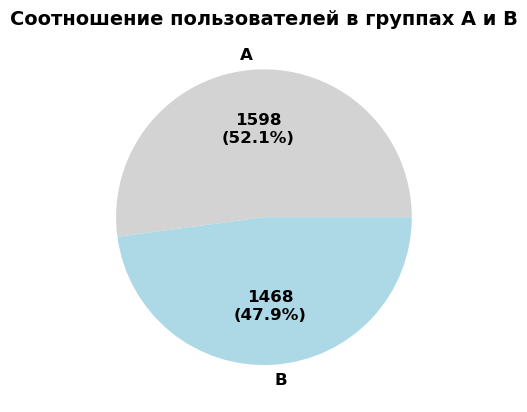

In [18]:
participants_test_2025_grp = participants_test_2025.groupby('group')['user_id'].nunique()
participants_test_2025_grp.plot(
    kind='pie',
    autopct=lambda x: f'{round(x * sum(participants_test_2025_grp)/100)}\n({x:.1f}%)', 
    ylabel='',
    textprops={'fontsize': 12, 'weight': 'bold'},
    colors=['lightgrey', 'lightblue'] 
)
plt.title('Соотношение пользователей в группах A и B', fontsize=14, weight = 'bold')
plt.show()

Соотношение пользователей в группах A и B вполне приемлемо для статистического теста.

- Присоединим к пользователям из таблицы `participants_test_2025` данные о пукупках, сессиях и датой регистрации

In [19]:
payment_funnel_test = (
    participants_test_2025
    .merge(purchases_test_2025, on='user_id', how='left')
    .merge(sessions_test_2025, on='user_id', how='left')
    .merge(new_users_test_2025, on='user_id', how='left')
)

In [20]:
payment_funnel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19137 entries, 0 to 19136
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           19137 non-null  object        
 1   group             19137 non-null  object        
 2   ab_test           19137 non-null  object        
 3   event_dt          10382 non-null  datetime64[ns]
 4   revenue           10382 non-null  float64       
 5   session_start     19137 non-null  datetime64[ns]
 6   session_duration  19137 non-null  float64       
 7   first_date        19137 non-null  datetime64[ns]
 8   region            19137 non-null  object        
 9   device            19137 non-null  object        
dtypes: datetime64[ns](3), float64(2), object(5)
memory usage: 1.5+ MB


Общий датасет `payment_funnel_test` состоит из 19137 строк и 10 столбцов и содержит данные о пользователях и событиях в рамках настоящего тестирования

- Проверим соотношение пользователей в группах по устройствам

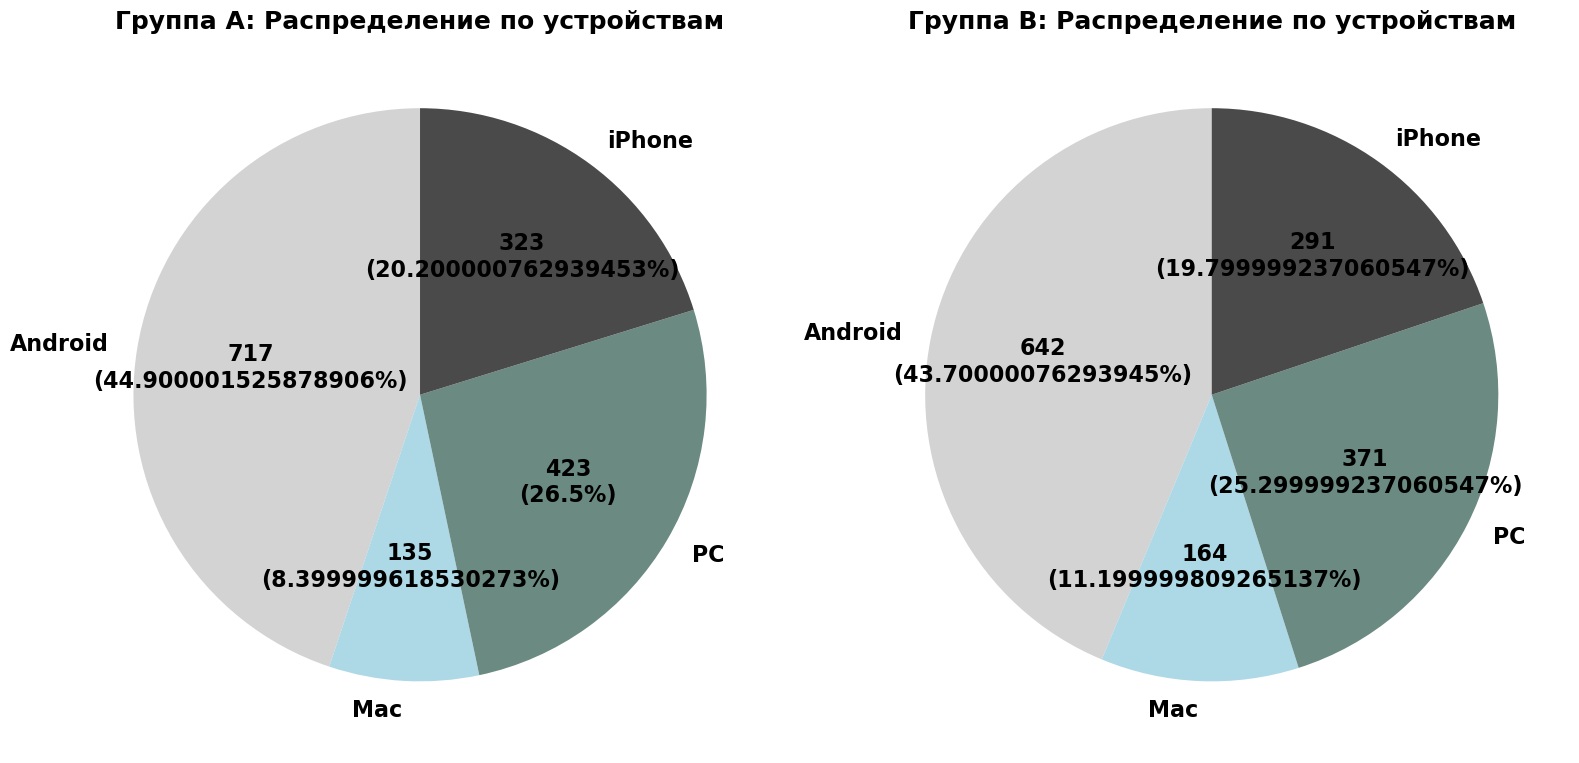

In [21]:

device_grp = payment_funnel_test.groupby(['device', 'group'])['user_id'].nunique()
group_a = device_grp.xs('A', level='group')
group_b = device_grp.xs('B', level='group')
# Функция для подписей: число + процент
def make_autopct(values):
    def autopct(x):
        total = sum(values)
        pct = round(x, 1)
        count = int(round(x * total / 100))
        return f'{count}\n({pct}%)'
    return autopct
# Создаем два подграфика
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
# Диаграмма для группы A
group_a.plot(
    kind='pie',
    autopct=make_autopct(group_a),
    startangle=90,
    ax=ax1,
    colors=['lightgrey', 'lightblue', '#6A8A82', '#4A4A4A'],
    textprops={'fontsize': 16, 'weight': 'bold'}
)
ax1.set_title('Группа A: Распределение по устройствам', fontsize=18, weight = 'bold')
ax1.set_ylabel('')
# Диаграмма для группы B
group_b.plot(
    kind='pie',
    autopct=make_autopct(group_b),
    startangle=90,
    ax=ax2,
    colors=['lightgrey', 'lightblue', '#6A8A82', '#4A4A4A'],
    textprops={'fontsize': 16, 'weight': 'bold'}
)
ax2.set_title('Группа B: Распределение по устройствам', fontsize=18, weight = 'bold')
ax2.set_ylabel('')
plt.tight_layout()
plt.show()

Соотношения распределений по группам и устройствам в пределах допустимого для корректного статистического анализа.

- Проверим соотношение пользователей в группах по регионам

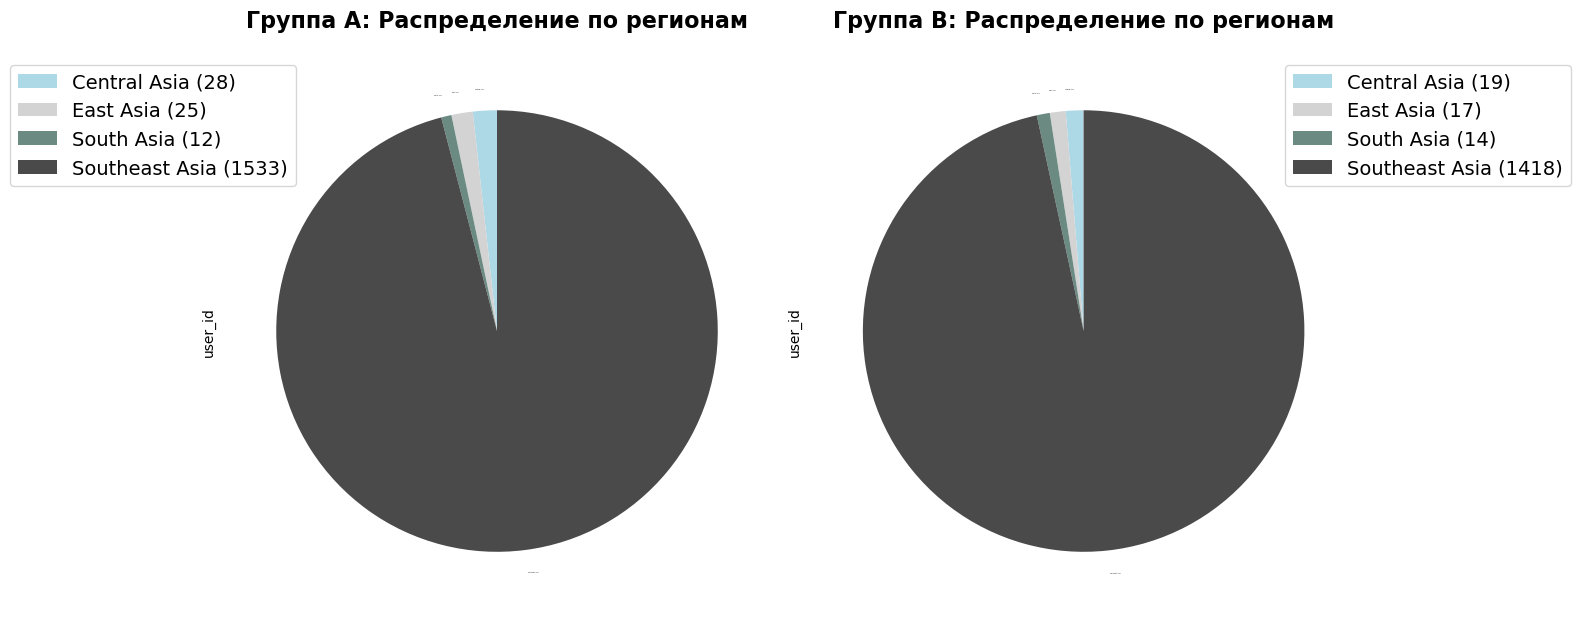

In [22]:
region_grp = payment_funnel_test.groupby(['region', 'group'])['user_id'].nunique()
group_a = region_grp.xs('A', level='group')
group_b = region_grp.xs('B', level='group')

# Создаем два подграфика
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Диаграмма для группы A
group_a.plot(
    kind='pie',
    startangle=90,
    ax=ax1,
    colors=['lightblue', 'lightgrey', '#6A8A82', '#4A4A4A'],
    textprops={'fontsize': 0},  # Убираем подписи (fontsize=0)
)
ax1.set_title('Группа A: Распределение по регионам', fontsize=16, weight='bold', pad=20)
ax1.legend(
    labels=[f'{label} ({val})' for label, val in zip(group_a.index, group_a)],  # Легенда: регион + значение
    loc='upper left',
    bbox_to_anchor=(-0.4, 1),  # Смещаем легенду левее диаграммы
    fontsize=14
)

# Диаграмма для группы B
group_b.plot(
    kind='pie',
    startangle=90,
    ax=ax2,
    colors=['lightblue', 'lightgrey', '#6A8A82', '#4A4A4A'],
    textprops={'fontsize': 0},  # Убираем подписи
)
ax2.set_title('Группа B: Распределение по регионам', fontsize=16, weight='bold', pad=20)
ax2.legend(
    labels=[f'{label} ({val})' for label, val in zip(group_b.index, group_b)],
    loc='upper right',
    bbox_to_anchor=(1.4, 1),  # Смещаем легенду правее диаграммы
    fontsize=14
)
plt.tight_layout()
plt.show()

Подавляющее большинство пользователей находятся в Юго-Восточной Азии. Распределение корректное для статистического анализа.

**Промежуточные выводы**

- Загружены и сохранены 4 датасета `new_users_test_2025`, `sessions_test_2025`, `purchases_test_2025`, `participants_test_2025`.
- Проверены и откорректированы типы данных в столбцах.
- В датасете `participants_test_2025` отфильтрованы данные только для пользователей, относящихся к настоящему A/B тесту.
- Группы проверены на пересечения и дубликаты.
- Определено количество и распределение пользователей по группам. Группа A: 1598 (52.1%). Группа B: 1468 (47.9%).
- Создан единый датафрейм `payment_funnel_test`, который содержит данные о пользователях и событиях в рамках настоящего A/B - тестирования.
- Проанализированы распределения пользователей в группах по категориям устройств и регионов. Соотношения между группами в допустимых пределах для дальнейшего статистического исследования.

## Шаг 2. Исследовательский анализ данных теста

Построим графики кумулятивной динамики метрик и проанализируем их.
Ответим на вопросы:
- Какой была конверсия в разных группах?
- Как выглядит кумулятивная динамика покупок?


- Метрики `session_duration`, `revenue`, конверсия `user_id`(`event_dt`)/`user_id`(`first_date`)
- Категории `group`, `region`, `device`

- Посчитаем количество пользователей в каждой группе, пользователей совершивших покупку и конверсию

In [23]:
users_A = payment_funnel_test.query("group == 'A'")['user_id'].nunique()
users_B = payment_funnel_test.query("group == 'B'")['user_id'].nunique()
payment_users_A = payment_funnel_test.query("event_dt.notna() and group == 'A'")['user_id'].nunique()
payment_users_B = payment_funnel_test.query("event_dt.notna() and group == 'B'")['user_id'].nunique()
conversion_A = payment_users_A/users_A
conversion_B = payment_users_B/users_B
print(f'Число пользователей в группе A: {users_A}')
print(f'Число пользователей в группе B: {users_B}')
print(f'Число покупателей в группе A: {payment_users_A}')
print(f'Число покупателей в группе B: {payment_users_B}')
print(f'Конверсия в группе A: {round(conversion_A, 3)*100}%')
print(f'Конверсия в группе B: {round(conversion_B, 3)*100}%')


Число пользователей в группе A: 1598
Число пользователей в группе B: 1468
Число покупателей в группе A: 472
Число покупателей в группе B: 270
Конверсия в группе A: 29.5%
Конверсия в группе B: 18.4%


Конверсия в тестовой группе B значительно ниже

- Для того чтобы сравнить накопленную выручку по группам построим линейный график

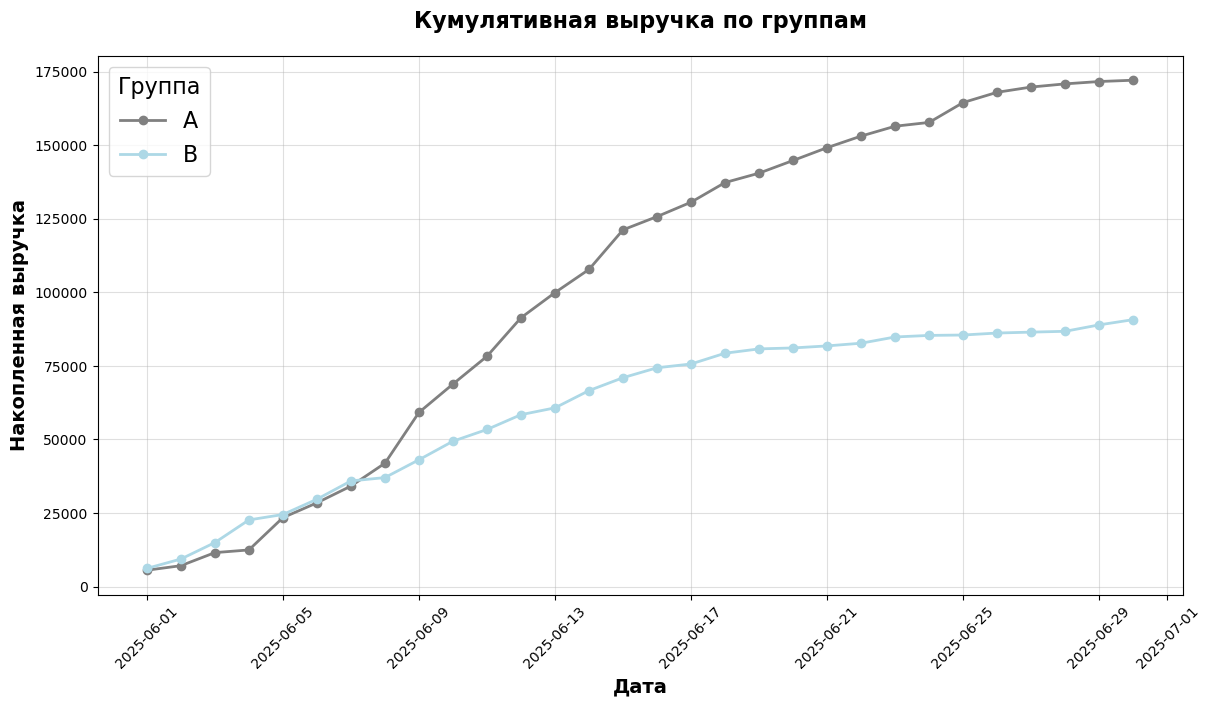

Максимальные значения накопленной выручки:
group  max_cumulative_revenue
    A                172132.0
    B                 90744.0


In [24]:
payment_funnel_test['event_dt'] = pd.to_datetime(payment_funnel_test['event_dt'], errors='coerce').dt.date
cumulative_revenue = (
    payment_funnel_test.groupby(['group', 'event_dt'])
    .agg({'revenue': 'sum'})
    .groupby(level='group')
    .cumsum()  # Накопление внутри каждой группы
    .reset_index()
    .rename(columns={'revenue': 'cumulative_revenue'})
)
plt.figure(figsize=(14, 7))
group_colors = {
    'A': 'grey',
    'B': 'lightblue'}
# Построение графиков для каждой группы
for group in cumulative_revenue['group'].unique():
    group_data = cumulative_revenue[cumulative_revenue['group'] == group]
    plt.plot(
        group_data['event_dt'], 
        group_data['cumulative_revenue'], 
        marker='o', 
        linestyle='-', 
        linewidth=2,
        label=f'{group}',
        color=group_colors.get(group, 'gray')
    )
plt.title('Кумулятивная выручка по группам', fontsize=16, pad=20, weight = 'bold')
plt.xlabel('Дата', fontsize=14, weight = 'bold')
plt.ylabel('Накопленная выручка', fontsize=14, weight = 'bold')
plt.xticks(rotation=45)
plt.legend(title='Группа', fontsize=16, title_fontsize=16)
plt.grid(alpha=0.4)
plt.show()
max_cumulative_revenue = (cumulative_revenue.groupby('group', as_index=False)['cumulative_revenue'].max().round().rename(columns={'cumulative_revenue': 'max_cumulative_revenue'})
)
print("Максимальные значения накопленной выручки:")
print(max_cumulative_revenue.to_string(index=False))

Динамика накопленной выручки после 7 июня для группы A испытывает ускоренный рост по сравнению с группой B. Максимальные значения накопленной суммы отличаются почти в 2 раза: 172132 для группы A и 90744 для группы B.

### Шаг 3. Проверка гипотез

Конверсия в этом тесте - ключевая метрика. Ранее мы вычислили, что она в группе B существенно ниже, поэтому, чтобы подтвердить этот расчет, в качестве альтернативной гипотезы примем вероятность успеха в группе B меньше, чем в группе A

Конверсия пользователей - долевая метрика, поэтому применим к ней статистический Z-тест пропорций:
- H0 - Нулевая гипотеза «вероятности успеха равны между группами A и B», p_a = p_b,
- H1 - Альтернативная гипотеза. Односторонняя. Вероятность успеха в группе B меньше, p_a > p_b.

In [25]:
n_a, n_b = users_A, users_B ## размеры выборок A и B
m_a = payment_users_A # количество успехов (регистраций) в группе A
m_b = payment_users_B # количество успехов (регистраций) в группе B
p_a, p_b = m_a/n_a, m_b/n_b # рассчитываем доли успехов для каждой группы: A и B
print(f'n_a={n_a}, n_b={n_b}')
print(f'm_a={m_a}, m_b={m_b}')
print(f'p_a={p_a}, p_b={p_b}')
if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

alpha = 0.05 
stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='larger'
)
p_value_ztest
if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

n_a=1598, n_b=1468
m_a=472, m_b=270
p_a=0.295369211514393, p_b=0.18392370572207084
Предпосылка о достаточном количестве данных выполняется!
pvalue=3.0669377655930017e-13 < 0.05
Нулевая гипотеза не находит подтверждения!


p-value в этом тесте близко к нулю, следовательно нулевая гипотеза отвергается и принимается альтернативная, согласно которой конверсия в группе B меньше, чем в группе A.

Выведем число покупок для каждой группы

In [26]:
payment_funnel_test.groupby('group')['revenue'].count()

group
A    6761
B    3621
Name: revenue, dtype: int64

Видим, что при практически равных количествах пользователей в группах, число покупок в группе A примерно в 2 раза больше. Это связано с более высокой конверсией пользователей в покупку, как мы уже выяснили. Это с одной стороны. С другой, чтобы выяснить как влияет нововведение на покупательскую способность платящих пользователей используем метрику Average Revenue Per Paying User (ARPPU) — средняя выручка на платящего пользователя, которая учитывает только пользователей, которые совершили хотя бы одну покупку.

In [27]:
payment_funnel_test.query("event_dt.notna()").groupby('group')['revenue'].mean().round(2)


group
A    25.46
B    25.06
Name: revenue, dtype: float64

Показатель ARPPU в группах A и B очень близок по значению с незначительным перевесом в сторону группы A. Проверим это различие с помощью статистического теста.

In [28]:
# Фильтруем платящих пользователей
paying_users = payment_funnel_test.query("event_dt.notna()")
# Выделяем данные по группам
group_a = paying_users[paying_users['group'] == 'A']['revenue']
group_b = paying_users[paying_users['group'] == 'B']['revenue']


Примененим t-тест Уэлча:
- Нулевая гипотеза (H₀): Средние значения ARPPU в группах A и B равны.
- Альтернативная гипотеза (H₁): Средние значения ARPPU в группах A и B не равны.
- уровень значимости alpha = 0.05

In [29]:
from scipy.stats import ttest_ind

stat, p = ttest_ind(group_a, group_b, equal_var=False)
print(f"p-value (t-тест Уэлча): {p:.4f}")

p-value (t-тест Уэлча): 0.7961


p-value > 0.05: Нет оснований отвергать H₀ различия статистически незначимы.
Таким образом новая платежная воронка не влияет на среднюю выручку на одного платящего пользователя.

### Шаг 4. Формулирование выводов и рекомендаций

**Выводы по результатам A/B-теста:**

---

### **1. Был ли тест проведён согласно техническому заданию?**
- **Да**, если целью теста было проверить влияние новой платёжной воронки на **конверсию в покупку**. Однако:
  - **Проблема**: Конверсия в группе B **снизилась** на ~11 процентных пунктов (с 29.5% до 18.4%), что противоречит гипотезе о её увеличении.
  - **Риск**: Возможно, техническое задание не учло факторов, вызвавших падение конверсии (например, ошибки в реализации воронки, UX-проблемы).

---

### **2. Было ли распределение на тестовые группы корректным?**
- **Да**, распределение можно считать корректным:
  - Группы **не пересекаются** (нет дубликатов пользователей).
  - Соотношение групп близко к **50/50** (A: 52.1%, B: 47.9%).
  - Распределение пользователей по устройствам и регионам **сбалансировано** между группами.

---

### **3. Наблюдается ли различие в целевых метриках между группами?**
- **Конверсия в покупку**:
  - Группа A: **29.5%**.
  - Группа B: **18.4%**.
  - **p-value ≈ 0** → Различие **статистически значимо**. Новая воронка **ухудшила конверсию**.
- **ARPPU (средняя выручка на платящего пользователя)**:
  - Различий между группами **нет** (p-value = 0.9518). Новая воронка не повлияла на средний чек.

---

### **4. Рекомендации для заказчика:**
1. **Отказаться от внедрения новой платёжной воронки**, так как она **снижает конверсию** и не даёт преимуществ в выручке на платящего пользователя.
2. **Провести качественный анализ причин падения конверсии**:
   - Изучить воронку на предмет UX-проблем (например, сложные шаги оформления заказа, ошибки валидации данных).
   - Проанализировать логи ошибок и отзывы пользователей группы B.
   - Проверить техническую реализацию воронки (работоспособность платежных методов, скорость загрузки).
3. **Запустить A/B-тесты для точечных улучшений**:
   - Протестировать упрощённые версии воронки (например, уменьшение числа шагов).
   - Проверить влияние персонализации (подсказки, автозаполнение полей).
4. **Мониторить долгосрочные эффекты**:
   - Оценить, не привело ли снижение конверсии к потере лояльных пользователей.

---

### **Итог:**
Новая платёжная воронка **не достигла заявленной цели** (увеличение конверсии) и **демонстрирует негативный эффект**. Решение о её дальнейшем использовании нецелесообразно. Рекомендуется сосредоточиться на устранении выявленных проблем и пересмотре гипотез для будущих тестов.